## Accumulate Local Effects (ALE) Documentation

This notebook demonstrates how to use `mintpy` to compute 1D or 2D ALE and plot the results. For more information on the dataset and initializing `InterpretToolkit`, see the permutatation importance notebook. The concept and calculation of ALE is to much to cover in this notebook. We highly recommend readers to check out Christoph Molnar's chapter on ALE (https://christophm.github.io/interpretable-ml-book/ale.html). 

In [15]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [16]:
import mintpy
import plotting_config

### Loading the training data and pre-fit models 

In [17]:
model_objs, model_names = mintpy.load_models()
examples, targets = mintpy.load_data()
examples = examples.astype({'urban': 'category', 'rural':'category'})

### Loading permutation importance results

To limit the scope of our analysis, we can start by only computing the ALE for the most important features. Assuming we have already run the permutation importance, we can pass those into `.get_important_vars`. If we are using multiple models, we can set `combine=True` and this function will make a single list of important predictors (removing duplicates). From this single list, we can ask for only a subset of features (`n_vars=7`). Otherwise, the function will return a dict with the model names as keys with the top features as items. 

In [18]:
myInterpreter = mintpy.InterpretToolkit(models=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )

# Load the permutation important results from the saved pickle file
results = myInterpreter.load_results(fnames='multipass_importance_naupdc.nc',)

# We can use a bulit-in function that will extract the top predictors from all the model
# remove any duplicate features to produce a single list. In this case, we want the top 7 features
important_vars = myInterpreter.get_important_vars(results, multipass=True, n_vars=7, combine=True)

### Plotting 1D ALE

Below is an example of 1D ALE plots for the top predictors. 

The following computes the 1D ALE curves for the features given. The arguments are as follows:
* `features`, a single feature or list of features to compute the 1D ALE for.
* `n_bootstrap`, number of bootstrap iterations to re-compute the 1D ALE to provide confidence intervals
* `subsample`, can be a float between 0-1 or an integer, which is interpreted as the percentage of examples or exact number of random samples to use, respectively. 
* `n_jobs`, number of processor to run the script on.
* `n_bins`, interger, the number of bins to compute the ALE. The bins are not evenly-spaced, but based on percentiles to ensure that a similar number of examples exist in each bin. Recommended to use > 30 bins. However, highly skewed data may not be divisable into more than 15-20 bins. This issue is handled internally by `mintpy`. 

For the ALE calculations, there is an accompanying tqdm bar showing the computation progress. 

In [21]:
results = myInterpreter.calc_ale(
                                 features=['temp2m'],
                                 n_bootstrap=1, 
                                 subsample=100, 
                                 n_jobs=6, 
                                 n_bins=100
                                )

KeyError: 'bad'

The results are stored as an `xarray.Dataset`. These results can be stored using built-in functions as compressed netcdf files. 

In [6]:
results

<xarray.Dataset>
Dimensions:                                (n_bins__date_marker: 40, n_bins__dwpt2m: 40, n_bins__sfc_temp: 40, n_bins__temp2m: 40, n_bootstrap: 1, n_examples: 100000)
Dimensions without coordinates: n_bins__date_marker, n_bins__dwpt2m, n_bins__sfc_temp, n_bins__temp2m, n_bootstrap, n_examples
Data variables:
    dwpt2m__Random Forest__ale             (n_bootstrap, n_bins__dwpt2m) float64 ...
    temp2m__Random Forest__ale             (n_bootstrap, n_bins__temp2m) float64 ...
    temp2m                                 (n_examples) float64 -1.909 ... 4.03
    date_marker                            (n_examples) float64 48.0 ... 33.0
    sfc_temp__Logistic Regression__ale     (n_bootstrap, n_bins__sfc_temp) float64 ...
    sfc_temp                               (n_examples) float64 -2.871 ... 3.38
    date_marker__Random Forest__ale        (n_bootstrap, n_bins__date_marker) float64 ...
    sfc_temp__Gradient Boosting__ale       (n_bootstrap, n_bins__sfc_temp) float64 ...
    sfc_temp__bin_values                   (n_bins__sfc_temp) float64 -23.44 ...
    temp2m__Logistic Regression__ale       (n_bootstrap, n_bins__temp2m) float64 ...
    sfc_temp__Random Forest__ale           (n_bootstrap, n_bins__sfc_temp) float64 ...
    dwpt2m                                 (n_examples) float64 -2.504 ... 1.399
    dwpt2m__Gradient Boosting__ale         (n_bootstrap, n_bins__dwpt2m) float64 ...
    temp2m__bin_values                     (n_bins__temp2m) float64 -9.545 .....
    dwpt2m__Logistic Regression__ale       (n_bootstrap, n_bins__dwpt2m) float64 ...
    date_marker__Logistic Regression__ale  (n_bootstrap, n_bins__date_marker) float64 ...
    date_marker__Gradient Boosting__ale    (n_bootstrap, n_bins__date_marker) float64 ...
    date_marker__bin_values                (n_bins__date_marker) float64 1.0 ...
    dwpt2m__bin_values                     (n_bins__dwpt2m) float64 -24.52 .....
    temp2m__Gradient Boosting__ale         (n_bootstrap, n_bins__temp2m) float64 ...
Attributes:
    model_output:  probability
    models used:   ['Random Forest', 'Gradient Boosting', 'Logistic Regression']
    method:        ale
    dimension:     1D

To personalize your plots, you can pass a dict `display_feature_names`, which should map the feature names with a prettier, more interpretable name. Additionally, you can color code your predictors with `feature_colors`, which maps the stored feature names to a color (see https://i.stack.imgur.com/nCk6u.jpg for a extension map of named colors in python). To see our example of `display_feature_names` and `feature_colors`, look in `plotting_config.py`. 

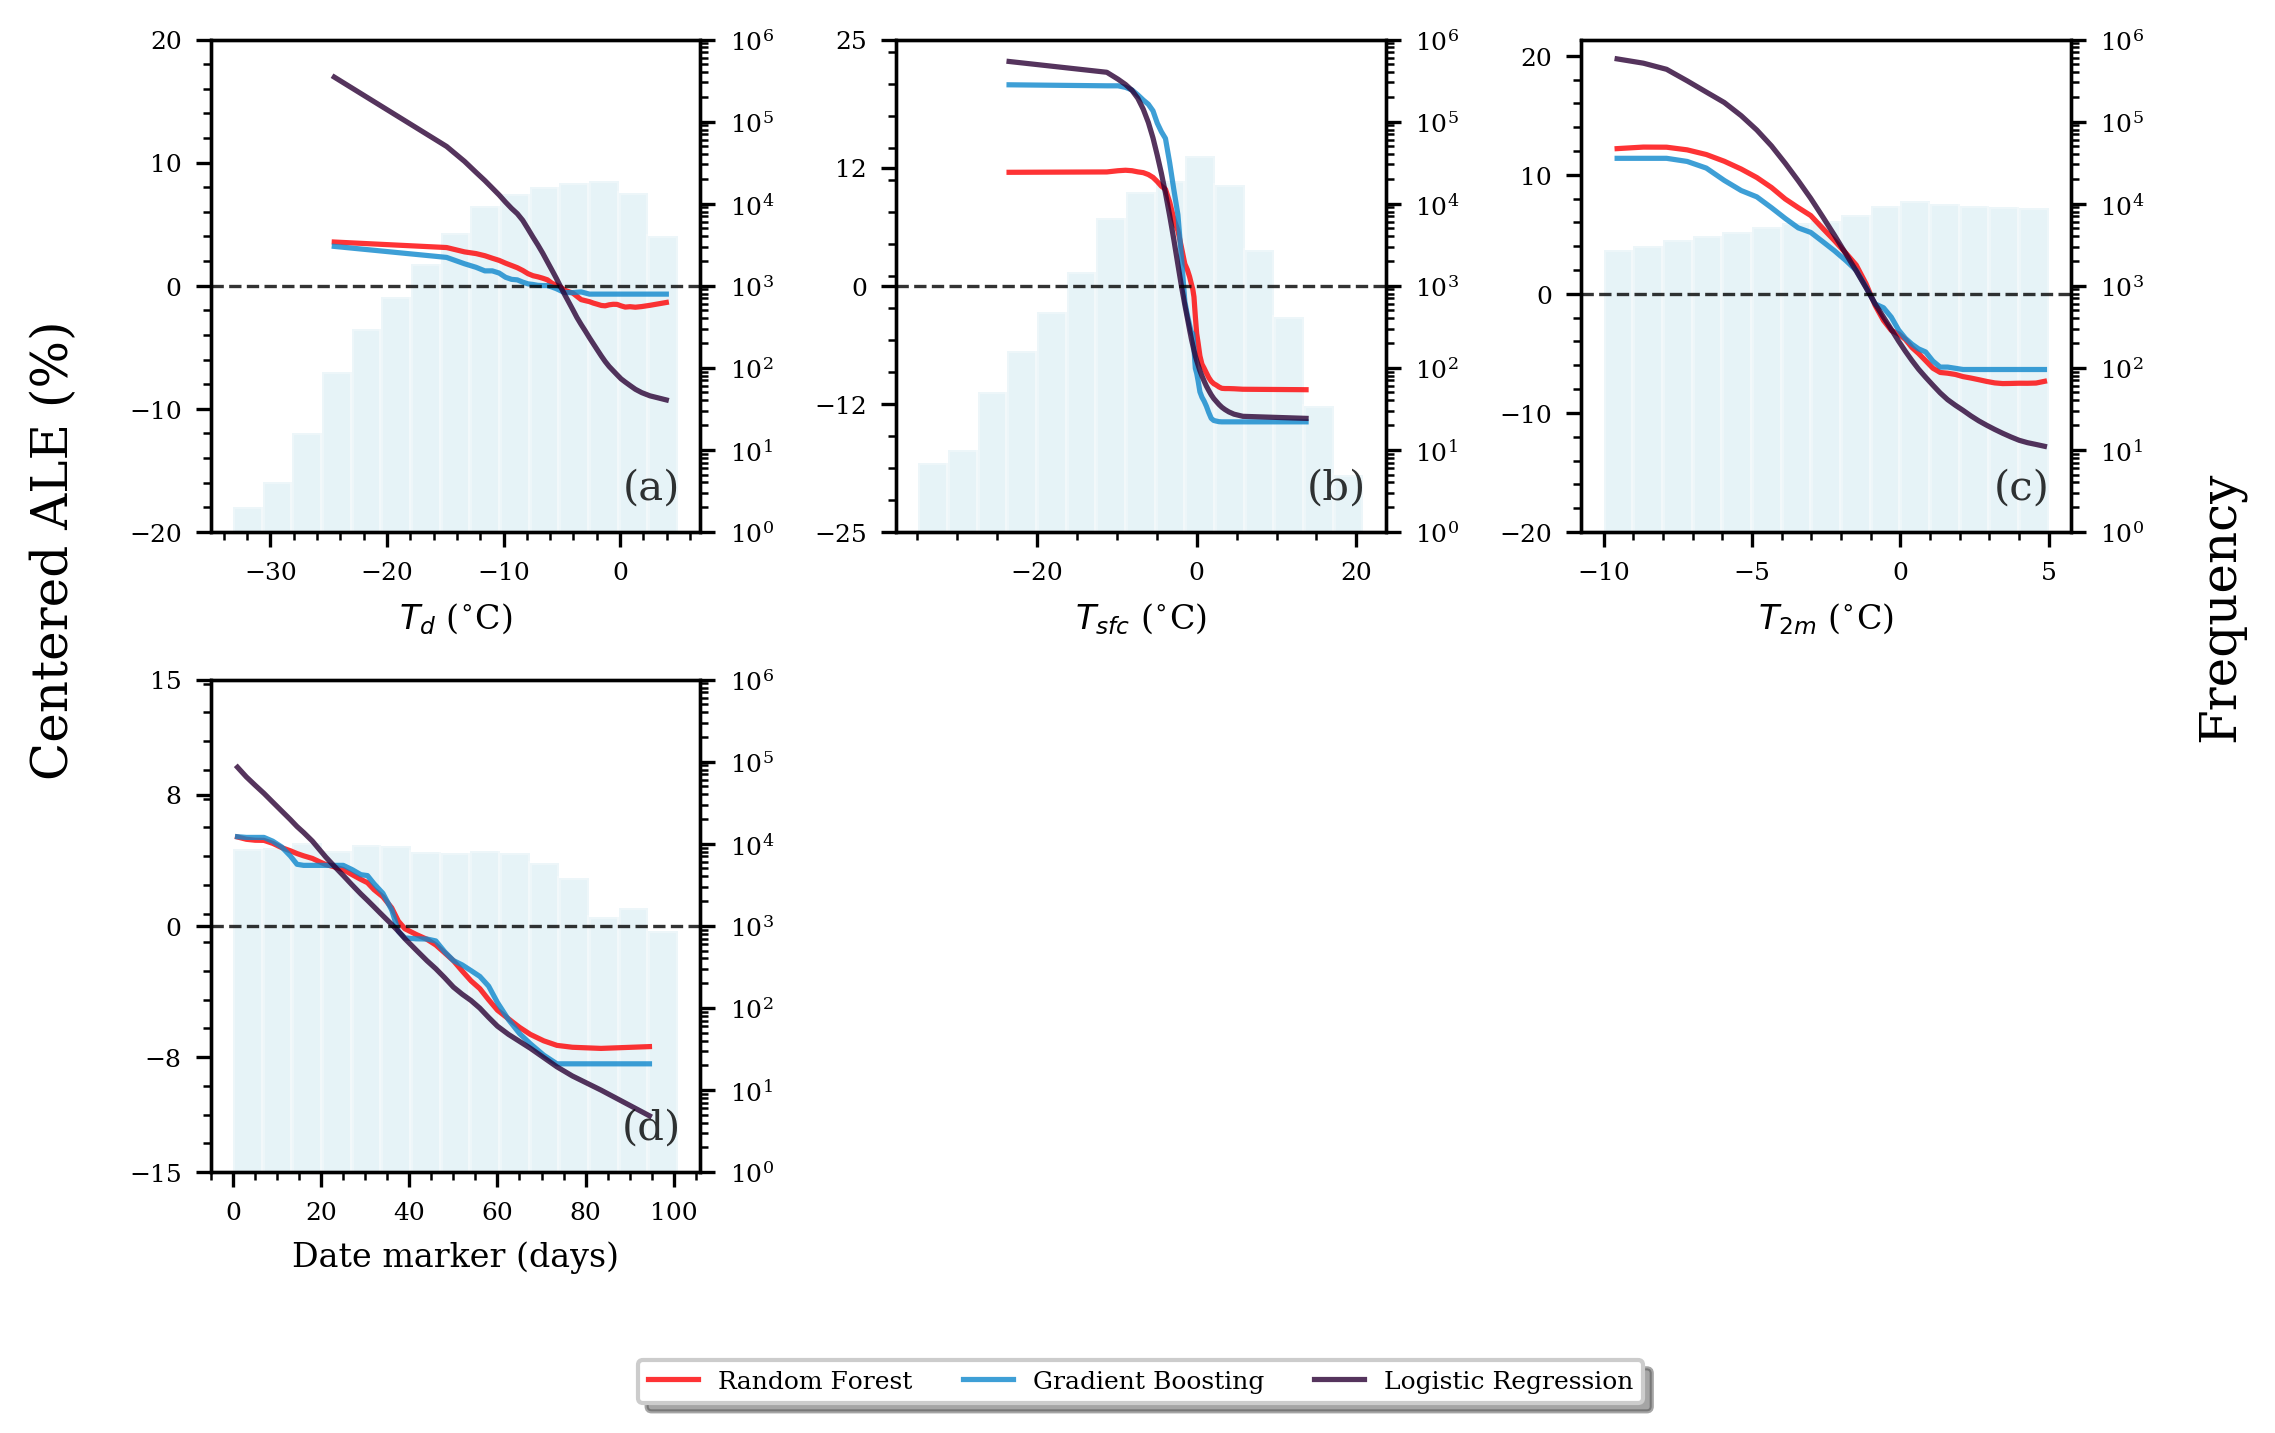

In [7]:
fig, axes = myInterpreter.plot_ale(
                                   data=results,
                                   display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

The light blue histogram in the background is the distribution of values the ALE was computed over. In instances where the distribution poorly samples particular phase space we should have less confident in the ALE value. The values of the curve for a particular feature value is interpreted as the expected contribution. For example, in panel (e), when the 2-m temperature ($T_{2m}$) is below 0$^{\circ}$C, the expected contribution is increasingly negative, varying between -6 - -12%, depending on the model. 

### Modifying line colors 

`mintpy` has default colors, which are designed to visually-pleasing. However, users are free to give their own colors using `line_colors`. 

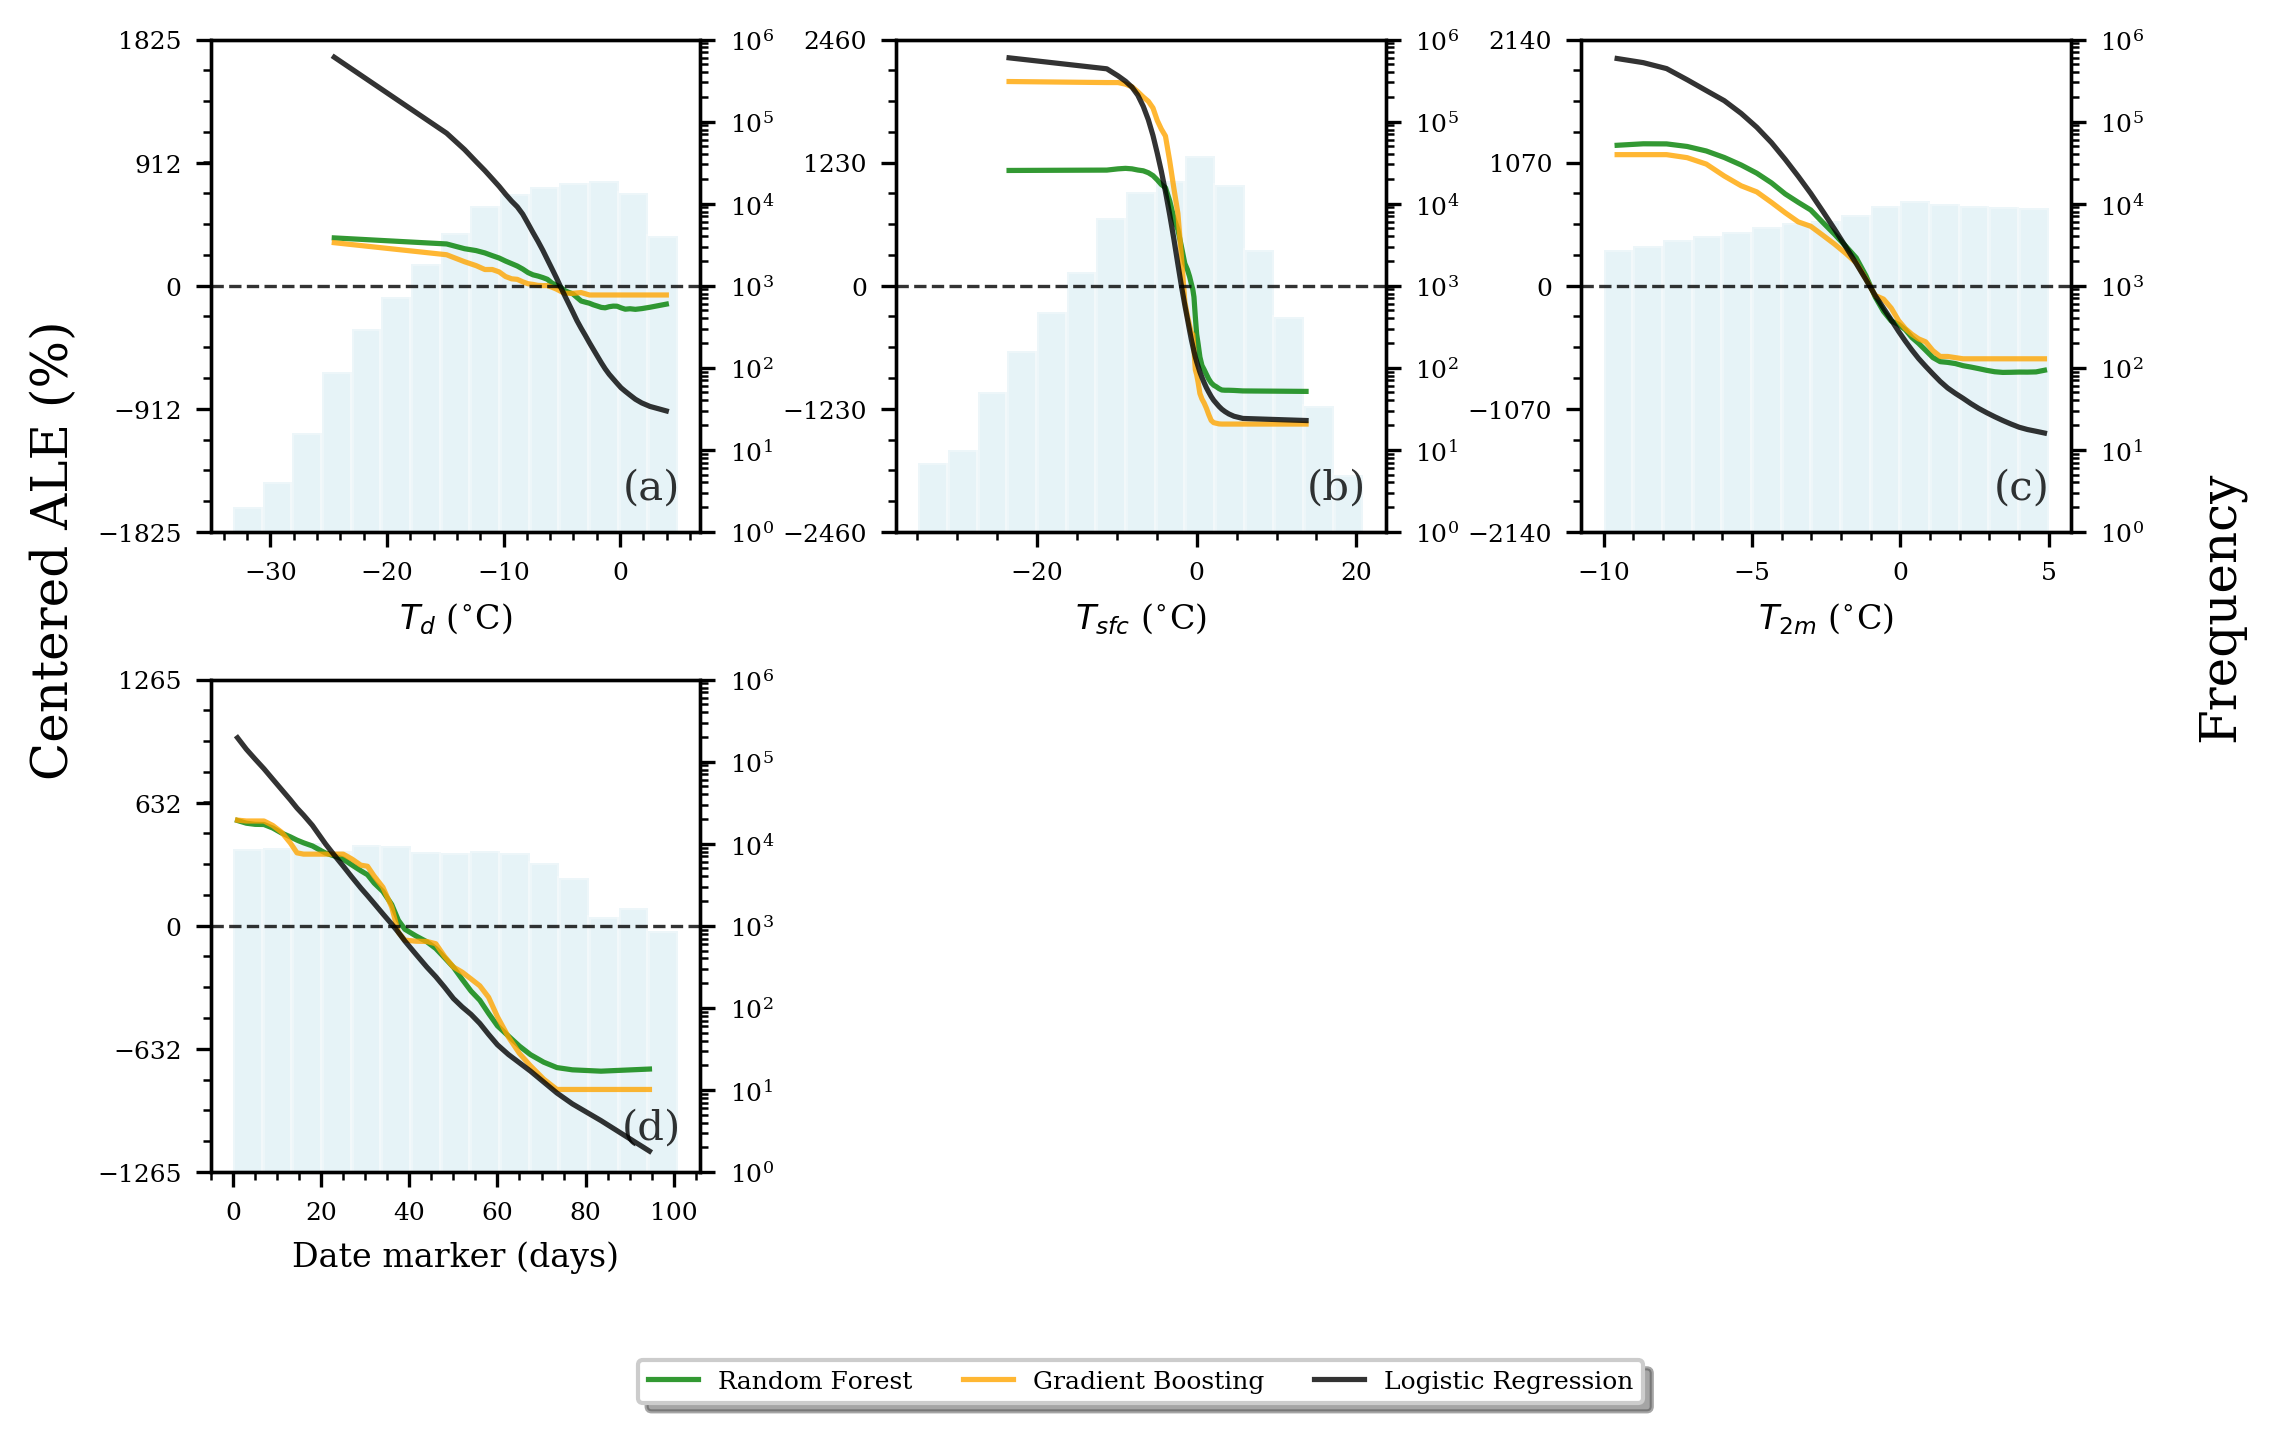

In [8]:
fig, axes = myInterpreter.plot_ale(display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                   line_colors = ['g', 'orange', 'k']
                                  )

### Including bootstrapping for confidence intervals

In some cases, there can be a some degree of uncertainty in ALE curves. To capture some of this uncertainty, we can 
use bootstrapping to compute confidence intervals. 

100%|██████████| 12/12 [00:20<00:00,  1.73s/it]


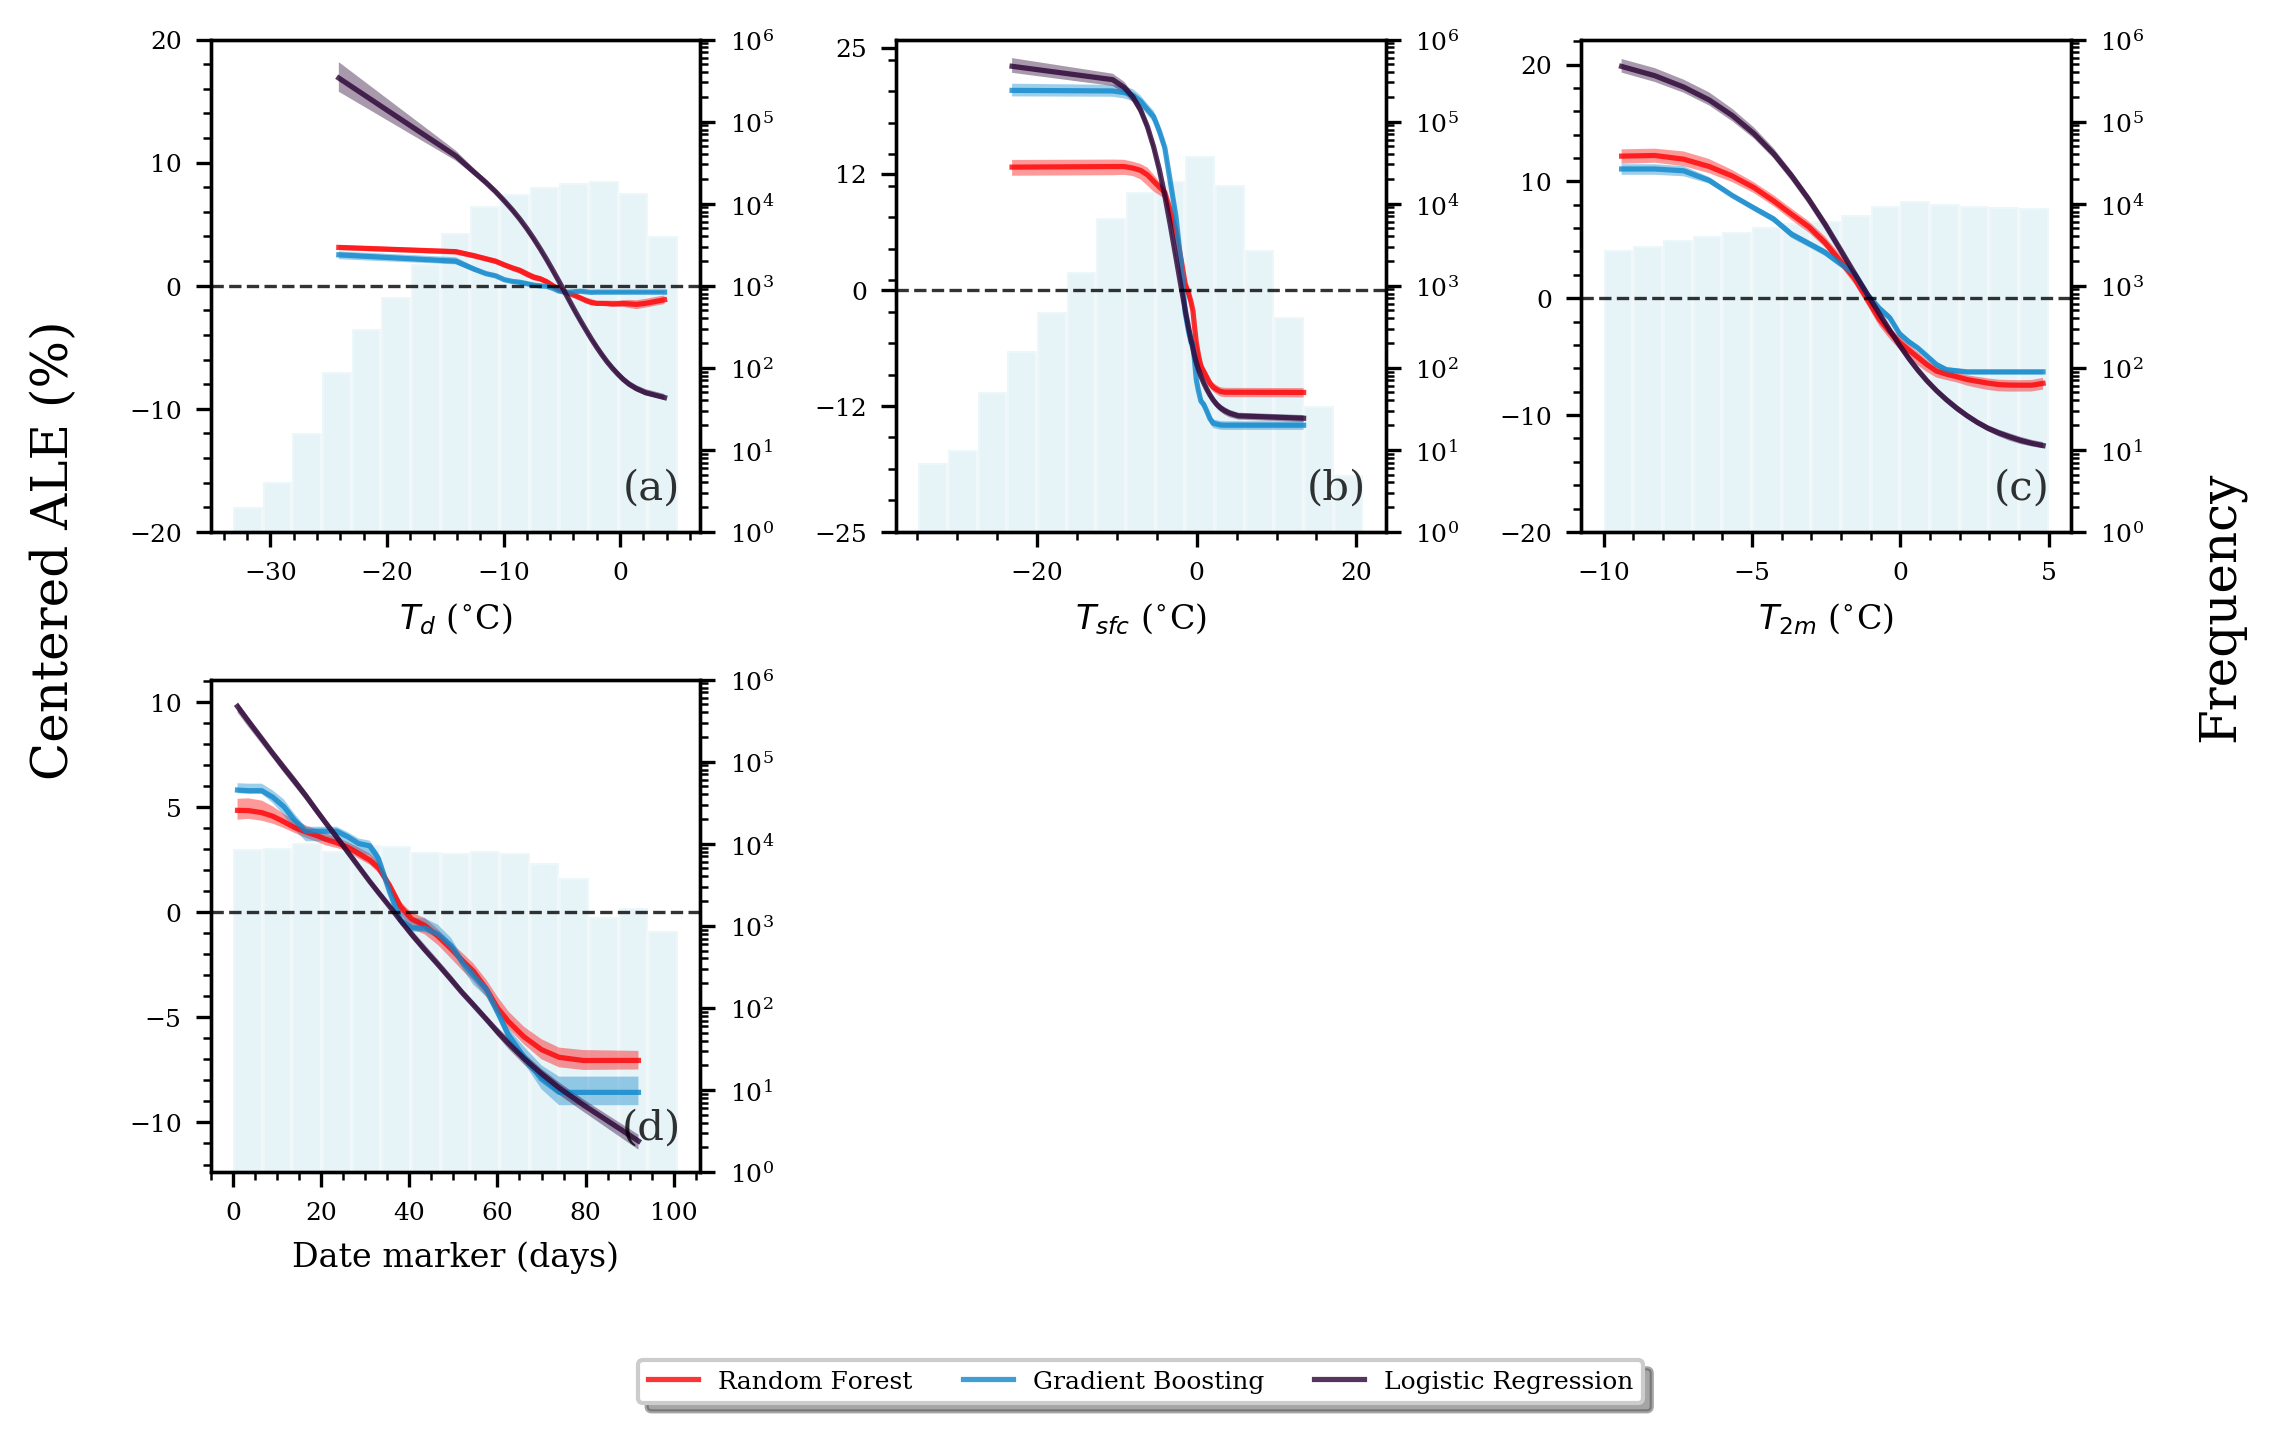

In [9]:
results = myInterpreter.calc_ale(features=important_vars, 
                                 n_bootstrap=10, 
                                 subsample=3000, 
                                 n_jobs=4, 
                                 n_bins=30
                                )
fig, axes = myInterpreter.plot_ale(display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

## Adding Individual Conditional Expectation (ICE) curves 

The ALE curves represent the expected contributions (the mean value), but when there is feature interactions, the actual contribution from a given feature can vary considerably from the expected value. If the reader is unaware of ICE curves, we highly recommend reading the following chapter: https://christophm.github.io/interpretable-ml-book/ice.html.

In this example, we will compute the ICE curves for only the random forest. To compute ICE curves, we call `.calc_ice`. The main argument for the ICE curves is the subsample size. Plotting more than 100-200 curves can make the plot hard to interpret, so we set the size at 200. 

In [10]:
myInterpreter = mintpy.InterpretToolkit(models=model_objs[0],
                                 model_names=model_names[0],
                                 examples=examples,
                                 targets=targets,
                                )
results = myInterpreter.calc_ale(features=important_vars, 
                                 n_bootstrap=1, 
                                 subsample=20000, 
                                 n_jobs=4, 
                                 n_bins=40
                                )

100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


In [11]:
ice_results = myInterpreter.calc_ice(features=important_vars, 
                                 subsample=200, 
                                 n_jobs=4, 
                                 n_bins=30
                                )

100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


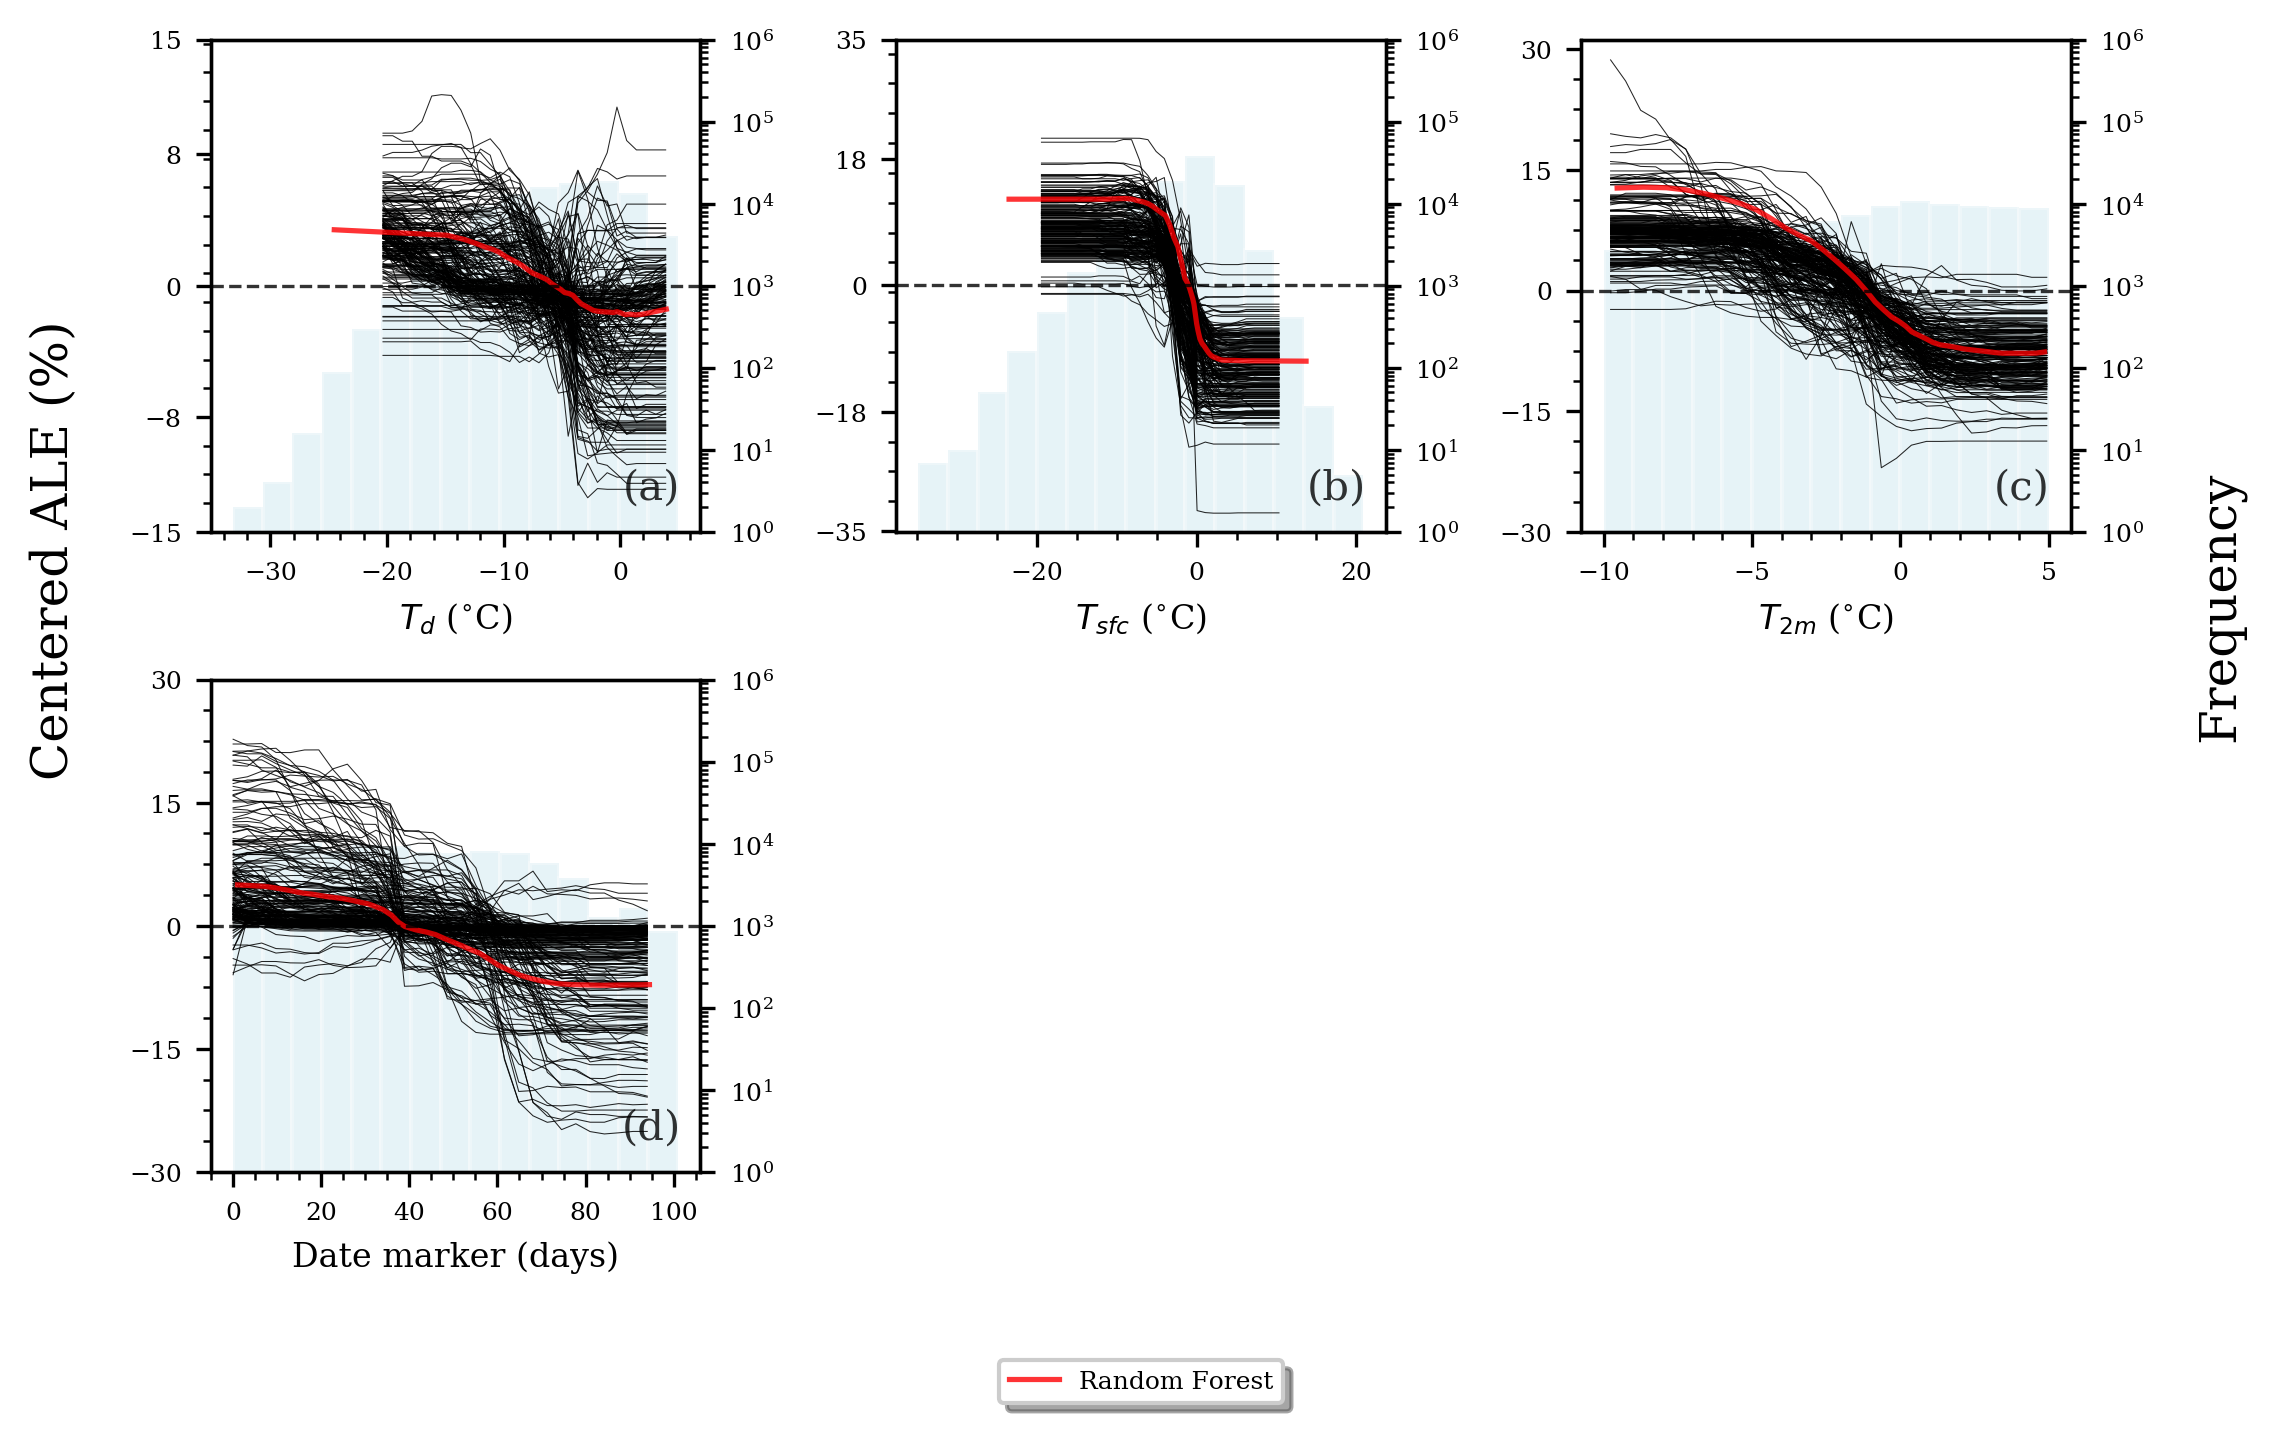

In [12]:
fig, axes = myInterpreter.plot_ale(display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                   ice_curves=ice_results, 
                                  )

ICE curves are a permutation-based method and therefore assumes feature dependence. Therefore, when we have dependent features, it can muddle our interpretation. The general idea is that the spread in the ICE curves about the expected contribution indicates feature interactions. Strong feature interactions produce greater variation in the ICE curves. 

### Plotting 2D ALE 

The previous examples showed the 1D ALE curves. It is also possible to compute the ALE between two features. In this case, we are measuring the additional contribution from the combination of the two features (minus their respective 1D effects). 

100%|██████████| 9/9 [00:18<00:00,  2.11s/it]


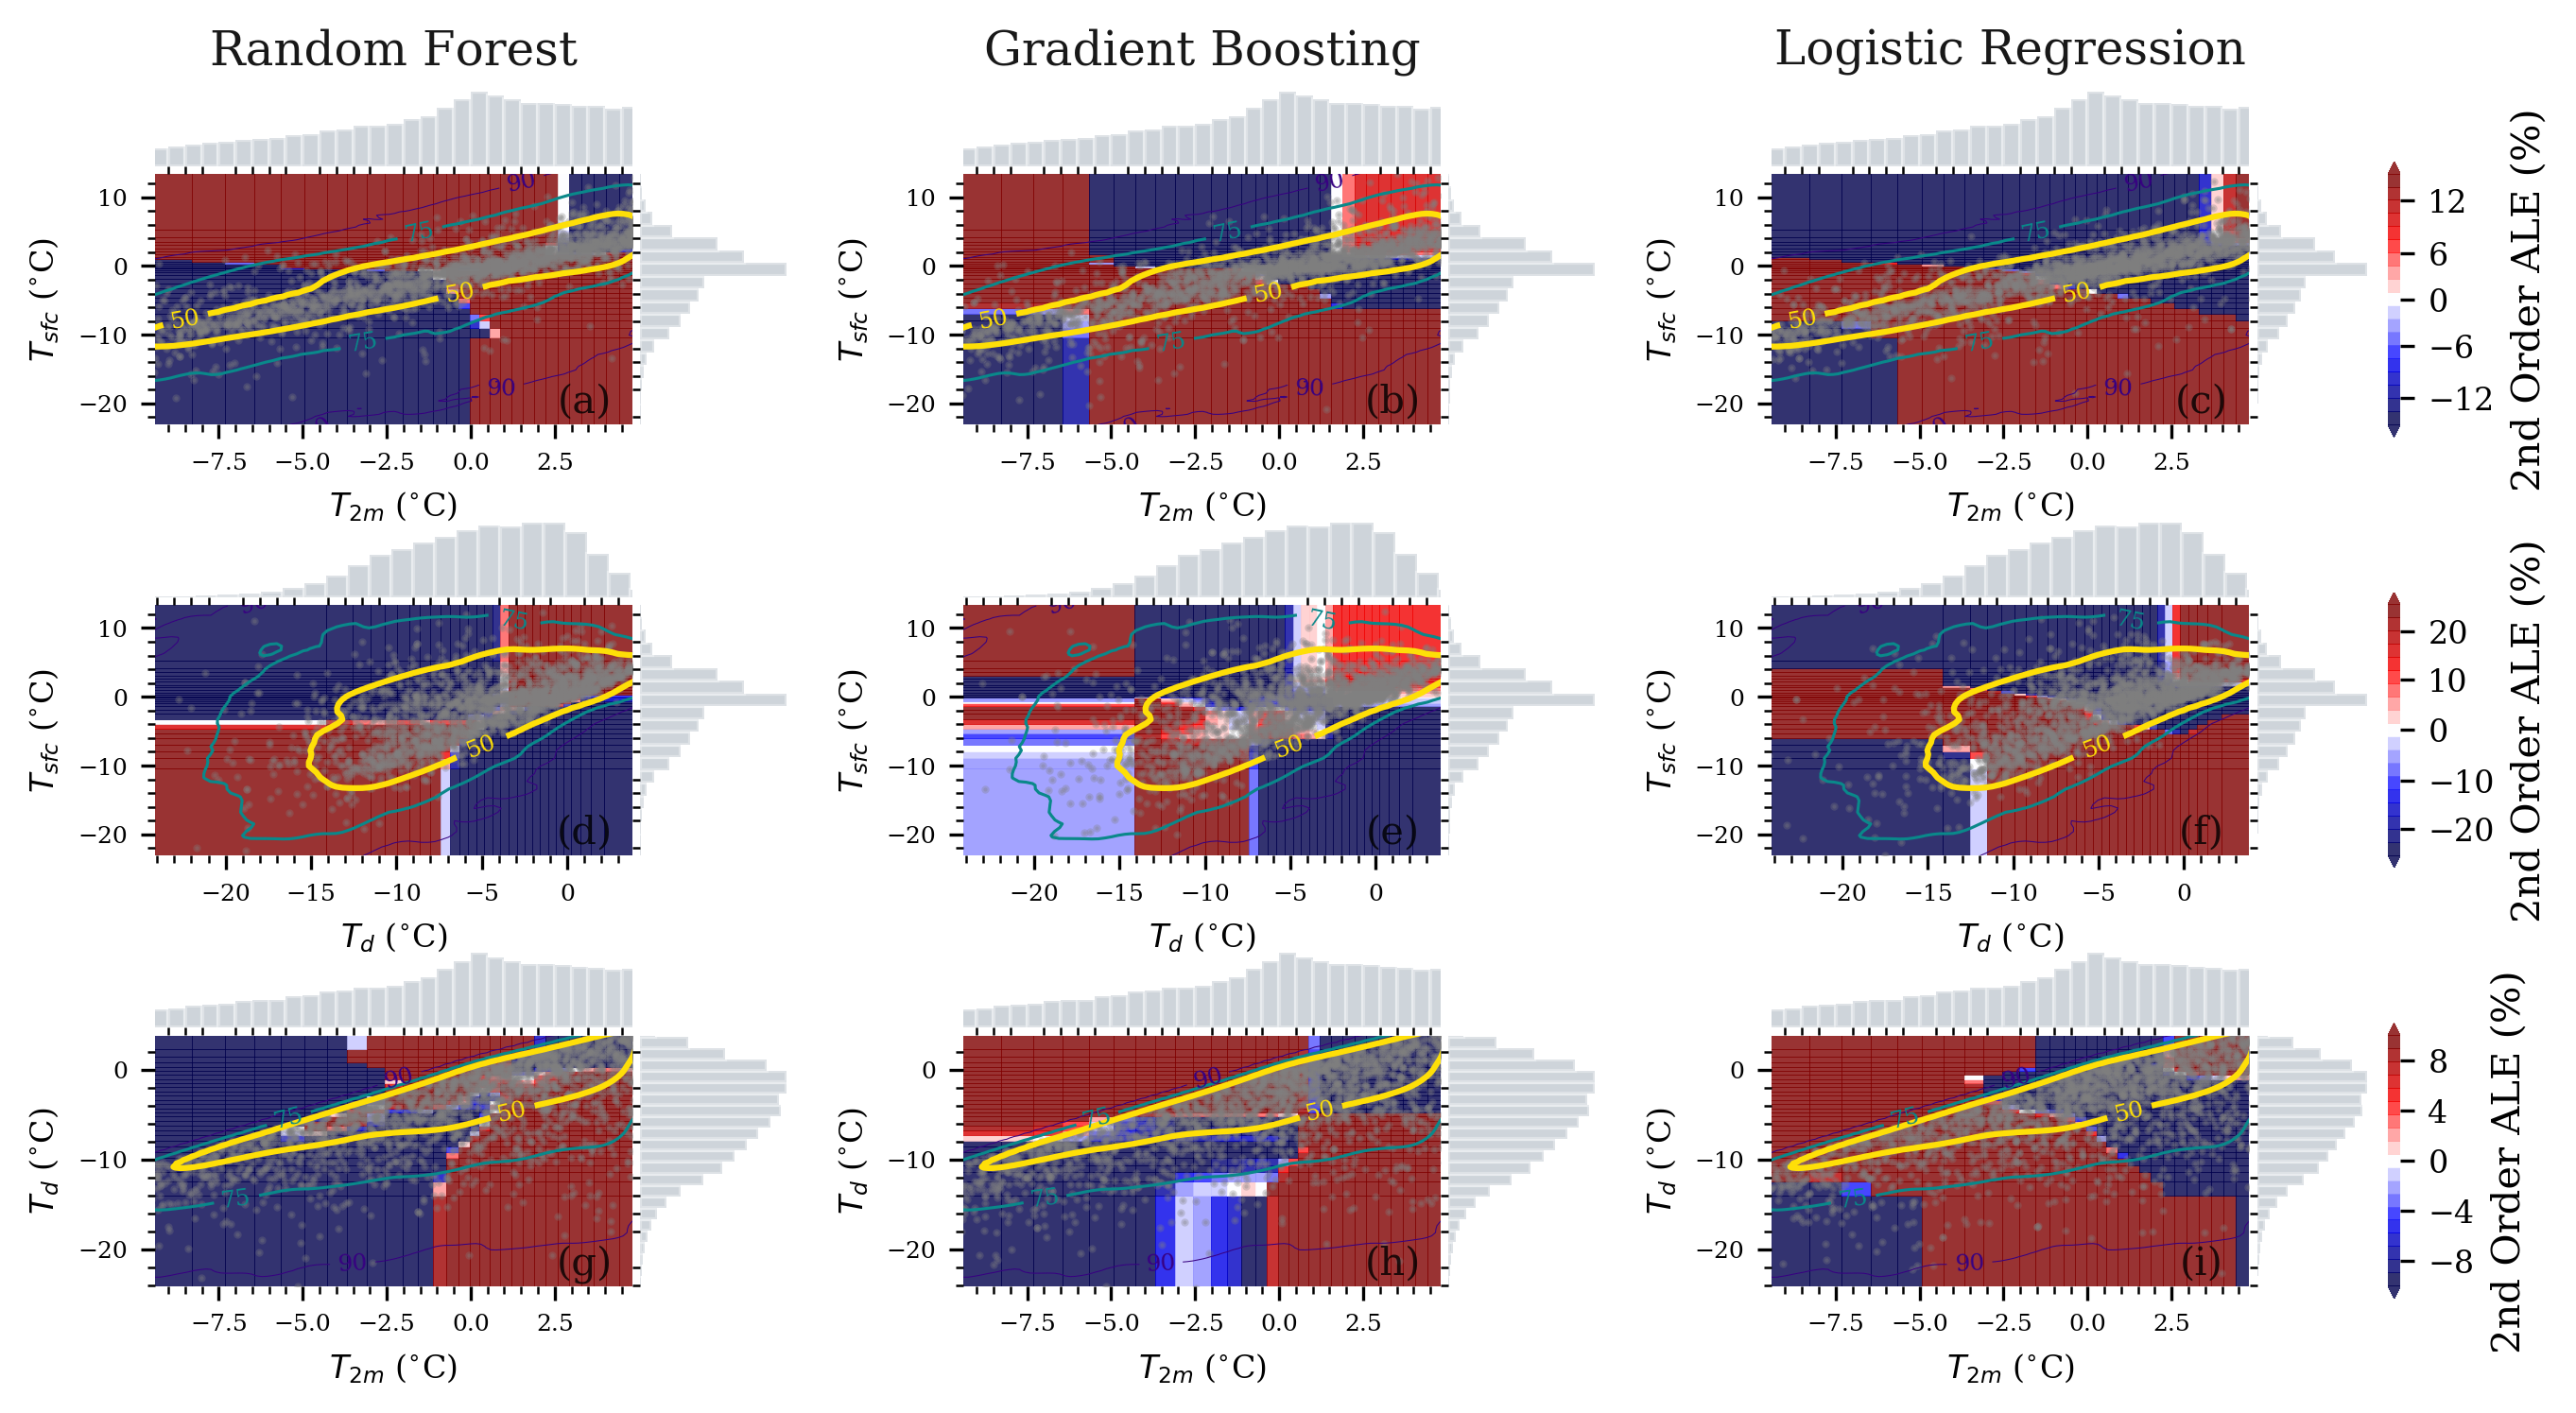

In [5]:
features=[('temp2m', 'sfc_temp'), ('dwpt2m', 'sfc_temp'), ('temp2m', 'dwpt2m')]
results = myInterpreter.calc_ale(features=features, 
                                 n_bootstrap=1, 
                                 subsample=1.0,
                                 n_jobs=len(features)*len(model_names),
                                 n_bins=30
                                )

fig, axes = myInterpreter.plot_ale(display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

In these plots, 
* The marignal distribution of the two features are shown in each panel
* A subsample of the actual data is shown as dots 
* The kernal density estimate of the dots is overlaid. 

In [6]:
results

<xarray.Dataset>
Dimensions:                                     (n_bins__dwpt2m: 30, n_bins__sfc_temp: 30, n_bins__temp2m: 30, n_binssfc_temp: 30, n_bootstrap: 1, n_examples: 100000)
Dimensions without coordinates: n_bins__dwpt2m, n_bins__sfc_temp, n_bins__temp2m, n_binssfc_temp, n_bootstrap, n_examples
Data variables:
    temp2m                                      (n_examples) float64 -1.909 ....
    dwpt2m__sfc_temp__Random Forest__ale        (n_bootstrap, n_bins__dwpt2m, n_bins__sfc_temp) float64 ...
    temp2m__sfc_temp__Random Forest__ale        (n_bootstrap, n_bins__temp2m, n_bins__sfc_temp) float64 ...
    temp2m__sfc_temp__Gradient Boosting__ale    (n_bootstrap, n_bins__temp2m, n_bins__sfc_temp) float64 ...
    dwpt2m__bin_values                          (n_bins__dwpt2m) float64 -24....
    temp2m__dwpt2m__Gradient Boosting__ale      (n_bootstrap, n_bins__temp2m, n_bins__dwpt2m) float64 ...
    dwpt2m__sfc_temp__Gradient Boosting__ale    (n_bootstrap, n_bins__dwpt2m, n_bins__sfc_temp) float64 ...
    temp2m__dwpt2m__Logistic Regression__ale    (n_bootstrap, n_bins__temp2m, n_bins__dwpt2m) float64 ...
    dwpt2m__sfc_temp__Logistic Regression__ale  (n_bootstrap, n_bins__dwpt2m, n_bins__sfc_temp) float64 ...
    temp2m__dwpt2m__Random Forest__ale          (n_bootstrap, n_bins__temp2m, n_bins__dwpt2m) float64 ...
    temp2m__bin_values                          (n_bins__temp2m) float64 -9.3...
    dwpt2m                                      (n_examples) float64 -2.504 ....
    sfc_temp                                    (n_examples) float64 -2.871 ....
    sfc_temp__bin_values                        (n_binssfc_temp) float64 -23....
    temp2m__sfc_temp__Logistic Regression__ale  (n_bootstrap, n_bins__temp2m, n_bins__sfc_temp) float64 ...
Attributes:
    model_output:  probability
    models used:   ['Random Forest', 'Gradient Boosting', 'Logistic Regression']
    method:        ale
    dimension:     2D

## Using ALE for feature rankings 

Though feature importance is defined with respect to model performance, we can also rank features by their magnitude of their expected contribution to a model's predictions. Inspired by Greenwell et al. (2018, https://arxiv.org/abs/1805.04755), we can compute the standard deviation of the ALE (rather PD) and those features with the highest standard deviation have the biggest range of contributions to a model's performance. This method has limitations though: 
* The standard deviation is affected by outliers and may skew the results. 
* When feature interactions are strong, the expected contribution can be biased. 

In [5]:
myInterpreter = mintpy.InterpretToolkit(models=model_objs[0],
                                 model_names=model_names[0],
                                 examples=examples,
                                 targets=targets,
                                )

myInterpreter.calc_ale(features=list(examples.columns), 
                                 n_bootstrap=1, 
                                 subsample=1.0,
                                 n_jobs=10,
                                 n_bins=30
                                )
results = myInterpreter.calc_ale_variance(model_name='Random Forest')

100%|██████████| 2/2 [00:11<00:00,  5.87s/it]


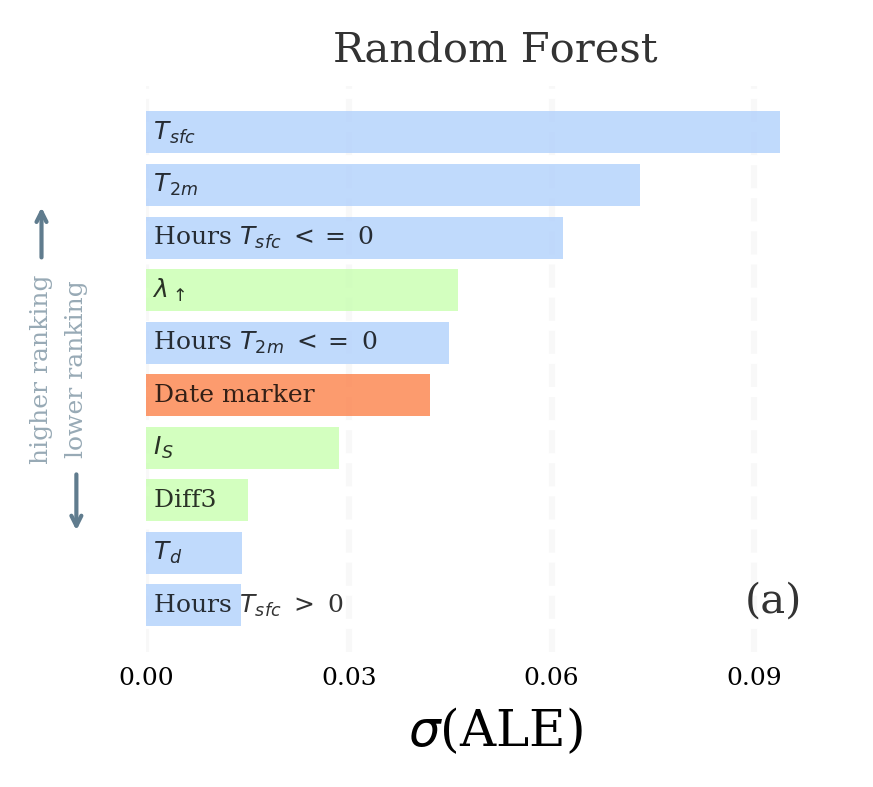

In [6]:
myInterpreter.plot_importance(
                              method='ale_variance', 
                              display_feature_names=plotting_config.display_feature_names,
                              feature_colors=plotting_config.color_dict,
                              num_vars_to_plot=10 
                             )

## ALE for Regression Problems

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [8]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
clf = RandomForestRegressor()
clf.fit(X,y)

RandomForestRegressor()

In [11]:
myInterpreter = mintpy.InterpretToolkit(models=clf,
                                 model_names='Random Forest',
                                 examples=X,
                                 targets=y,
                                 feature_names = feature_names
                                )

100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


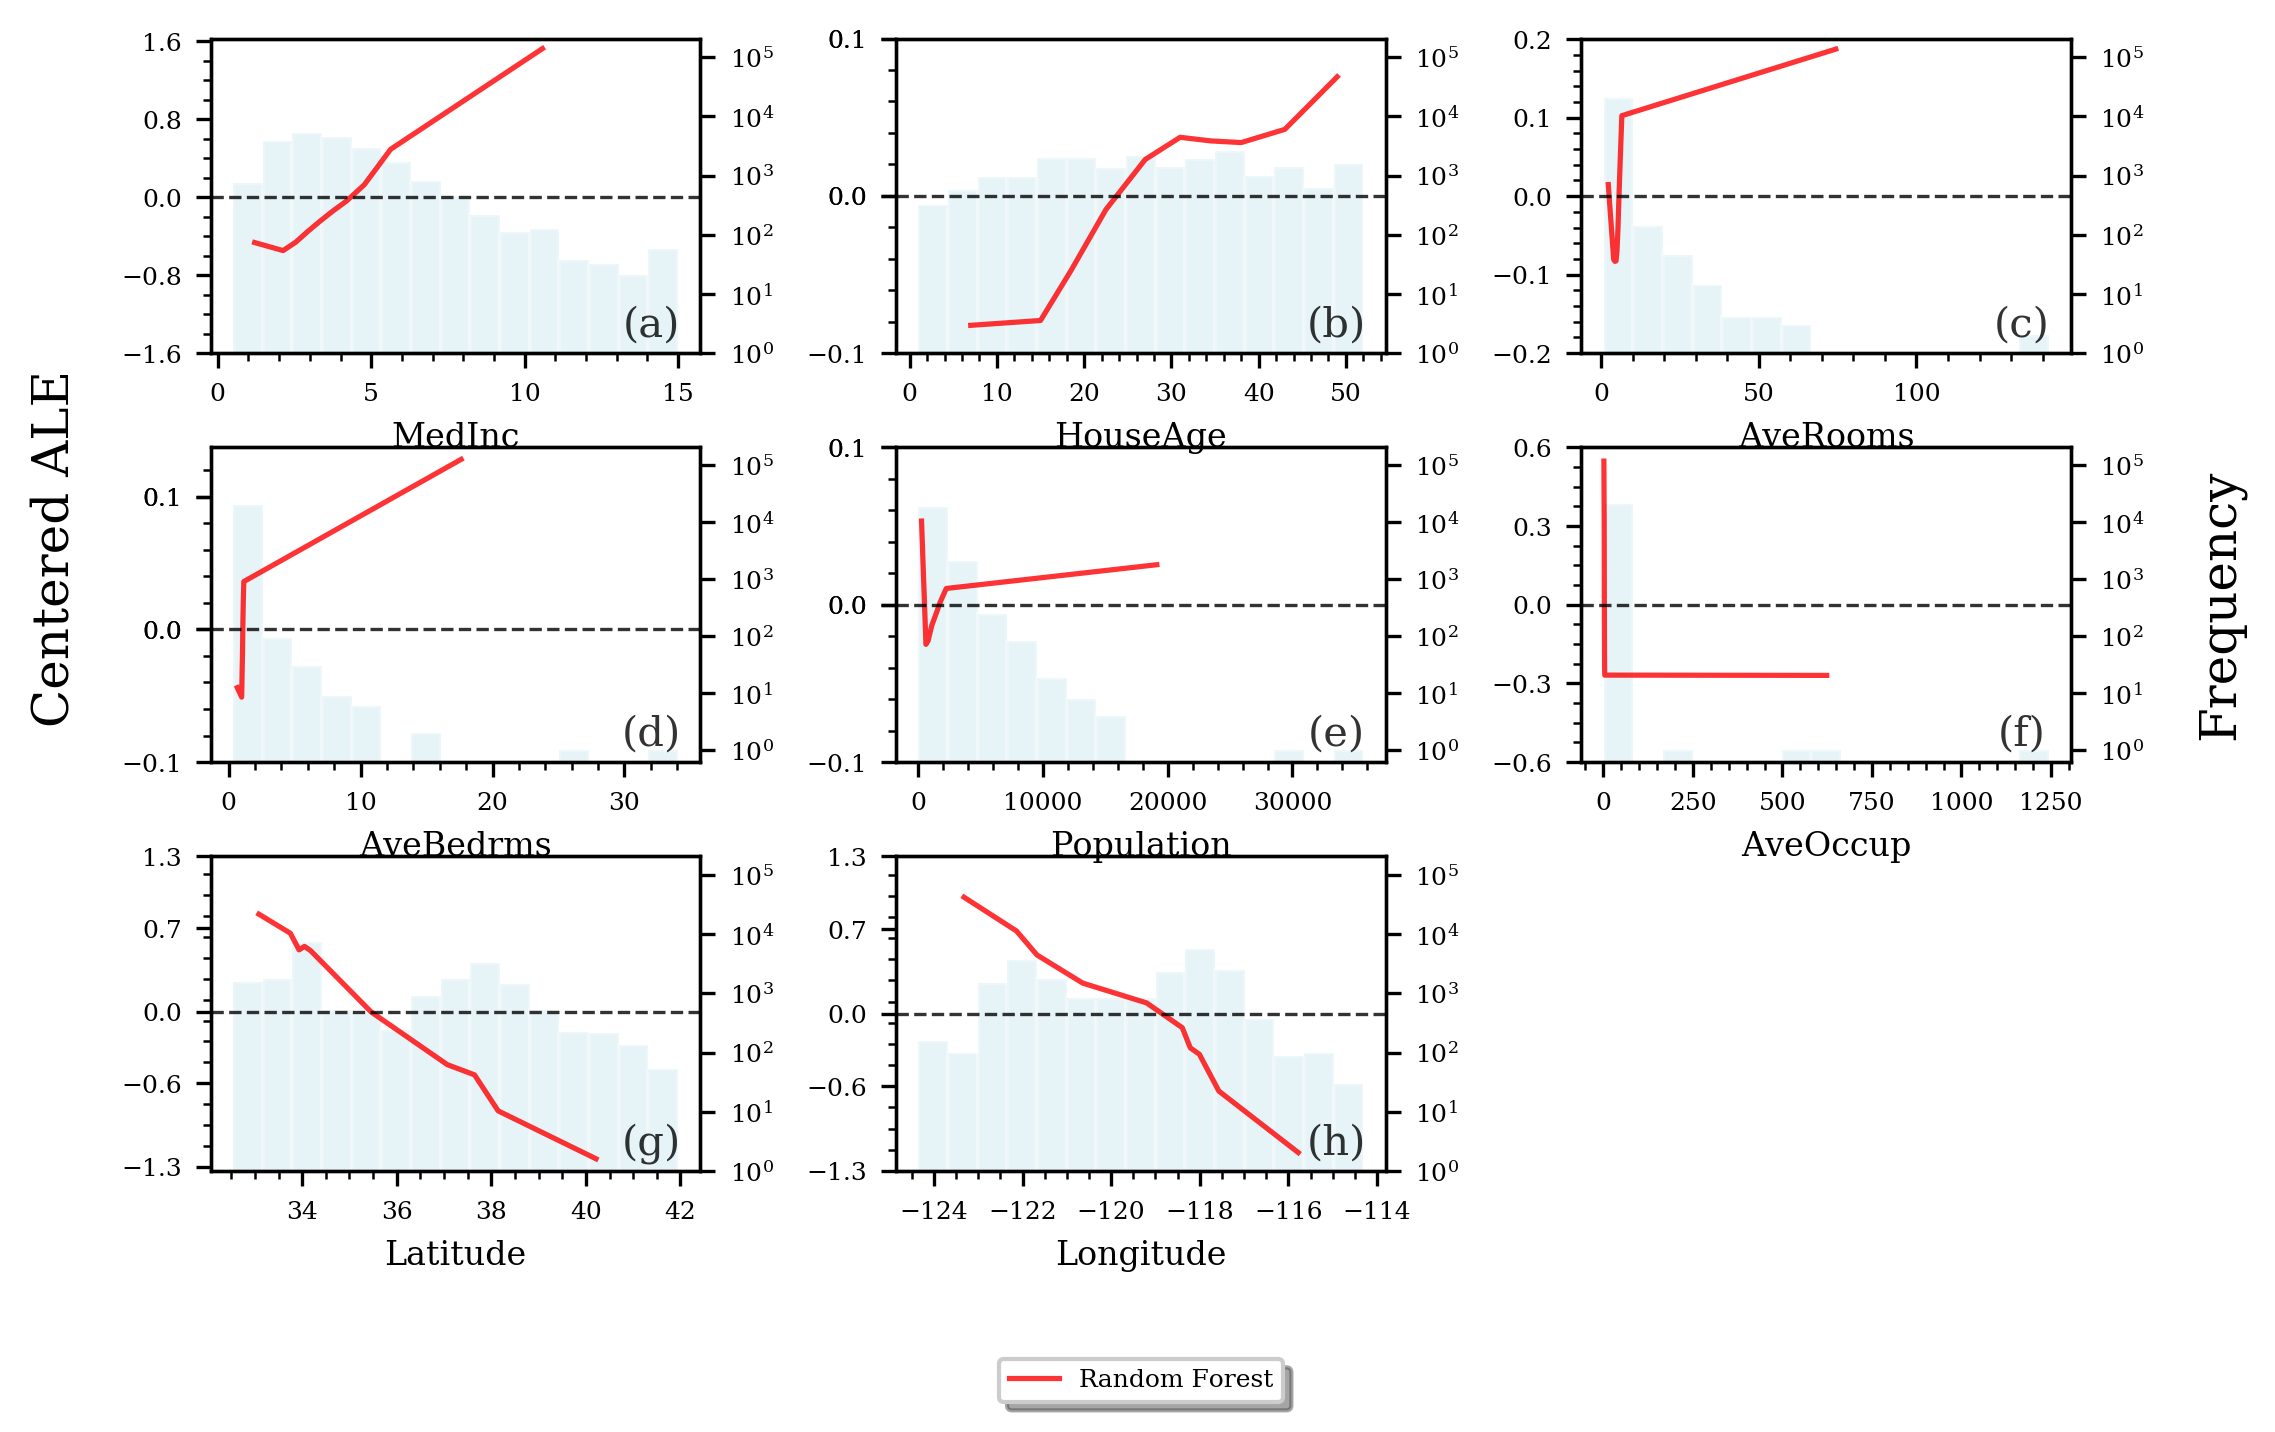

In [12]:
results = myInterpreter.calc_ale(features=feature_names, 
                                 n_bootstrap=1, 
                                 subsample=10000, 
                                 n_jobs=6, 
                                 n_bins=10
                                )
fig, axes = myInterpreter.plot_ale()

### Computing Interaction Strength 

Using ALE, we can compute the degree to which our model exhibits strong feature interactions. If the model can be sufficiently approximated by the first-order ALE, then feature interactions are weak. We compute the interaction strength statistc (IAS) from Molnar et al. 2019 (https://arxiv.org/abs/1904.03867). The IAS varies between 0-1 where 0 indicates no feature interactions (such a situation only occurs in purely additive models). 

In [13]:
ias = myInterpreter.calc_interaction_strength(model_names='Random Forest', 
                                   n_bins=30, 
                                   subsample=1.0, 
                                   n_jobs=10, 
                                   n_bootstrap=1,
                                   ale_subsample=1.0)

100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


In [14]:
print(ias['Random Forest'][0])

0.30230986632587653


An IAS=0.3 indicates that there is some decent feature interaction.  